In [4]:
import os
import sys
import random
import json
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torchvision import transforms

# Add project root to path
sys.path.append('..')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# For better plots in notebook
%matplotlib inline

# Tiny ImageNet-200 Data Exploration

**Purpose:** This notebook explores the Tiny ImageNet-200 dataset to understand its structure, distribution, and characteristics before training models.

**Key Analyses:**
- Dataset structure and class distribution
- Sample image visualization across classes
- Image statistics for normalization
- Data augmentation techniques and effects

## 1. Dataset Structure Analysis

Overview of the dataset organization, including the number of classes, total images, and split between training and validation sets. This confirms that the dataset is balanced with exactly 500 images per class in training and 10,000 images in validation.

In [ ]:
def analyze_dataset_structure(data_dir="../data/raw/tiny-imagenet-200"):
    """Analyze the structure of the dataset"""
    data_path = Path(data_dir)
    train_dir = data_path / "train"
    val_dir = data_path / "val"
    
    # Count training samples per class
    train_counts = {}
    for class_dir in train_dir.iterdir():
        if class_dir.is_dir():
            images_dir = class_dir / "images"
            if images_dir.exists():
                num_images = len(list(images_dir.glob("*.JPEG")))
                train_counts[class_dir.name] = num_images
    
    # Count validation samples
    val_images = list((val_dir / "images").glob("*.JPEG")) if (val_dir / "images").exists() else []
    
    print("="*80)
    print("DATASET STRUCTURE ANALYSIS")
    print("="*80)
    print(f"\nTraining Set:")
    print(f"  Number of classes:      {len(train_counts)}")
    print(f"  Total images:           {sum(train_counts.values()):,}")
    print(f"  Images per class:       {list(train_counts.values())[0] if train_counts else 0}")
    
    print(f"\nValidation Set:")
    print(f"  Total images:           {len(val_images):,}")
    
    print("\n" + "="*80 + "\n")
    
    return train_counts

train_counts = analyze_dataset_structure()

DATASET STRUCTURE ANALYSIS

Training Set:
  Number of classes:      200
  Total images:           100,000
  Images per class:       500

Validation Set:
  Total images:           10,000




## 2. Class Distribution Visualization

A histogram displaying how images are distributed across the 200 classes. Since this is a balanced dataset, all classes have exactly 500 training images each, resulting in a uniform distribution. This eliminates class imbalance as a training concern.

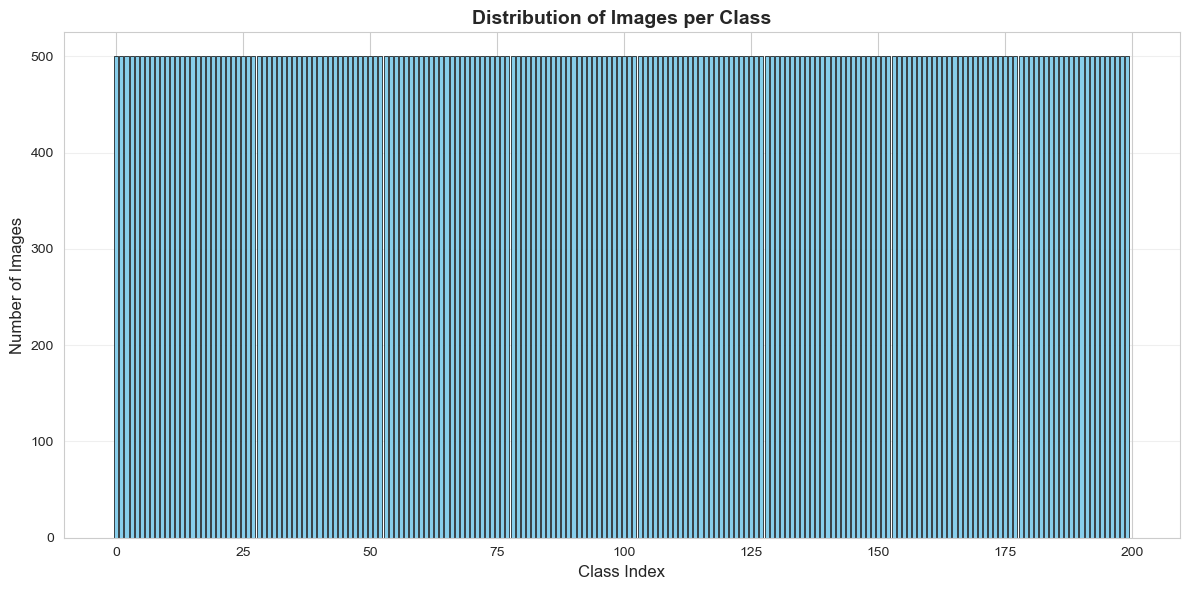

Min images per class: 500
Max images per class: 500
Mean images per class: 500.0
Std images per class: 0.0


In [ ]:
# Class distribution histogram
plt.figure(figsize=(12, 6))
class_ids = list(train_counts.keys())
counts = list(train_counts.values())
plt.bar(range(len(class_ids)), counts, color='skyblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Class Index', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Images per Class', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Min images per class: {min(counts)}")
print(f"Max images per class: {max(counts)}")
print(f"Mean images per class: {np.mean(counts):.1f}")
print(f"Std images per class: {np.std(counts):.1f}")

## 3. Sample Images Visualization

Random sample images from different classes to give a visual understanding of the dataset diversity. This helps identify the visual complexity, object scales, backgrounds, and overall image quality we'll be working with. Note the variety in object types, perspectives, and scene contexts.

In [1]:
def load_class_names(class_names_file="../data/class_mappings/class_names.txt"):
    """Load human-readable class names"""
    with open(class_names_file, 'r') as f:
        class_names = [line.strip() for line in f]
    return class_names

class_names = load_class_names()

/var/folders/8j/jz27y6g50kj22b3f9kkxc_qc0000gp/T/ipykernel_67841/1604798065.py:48: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  plt.tight_layout()


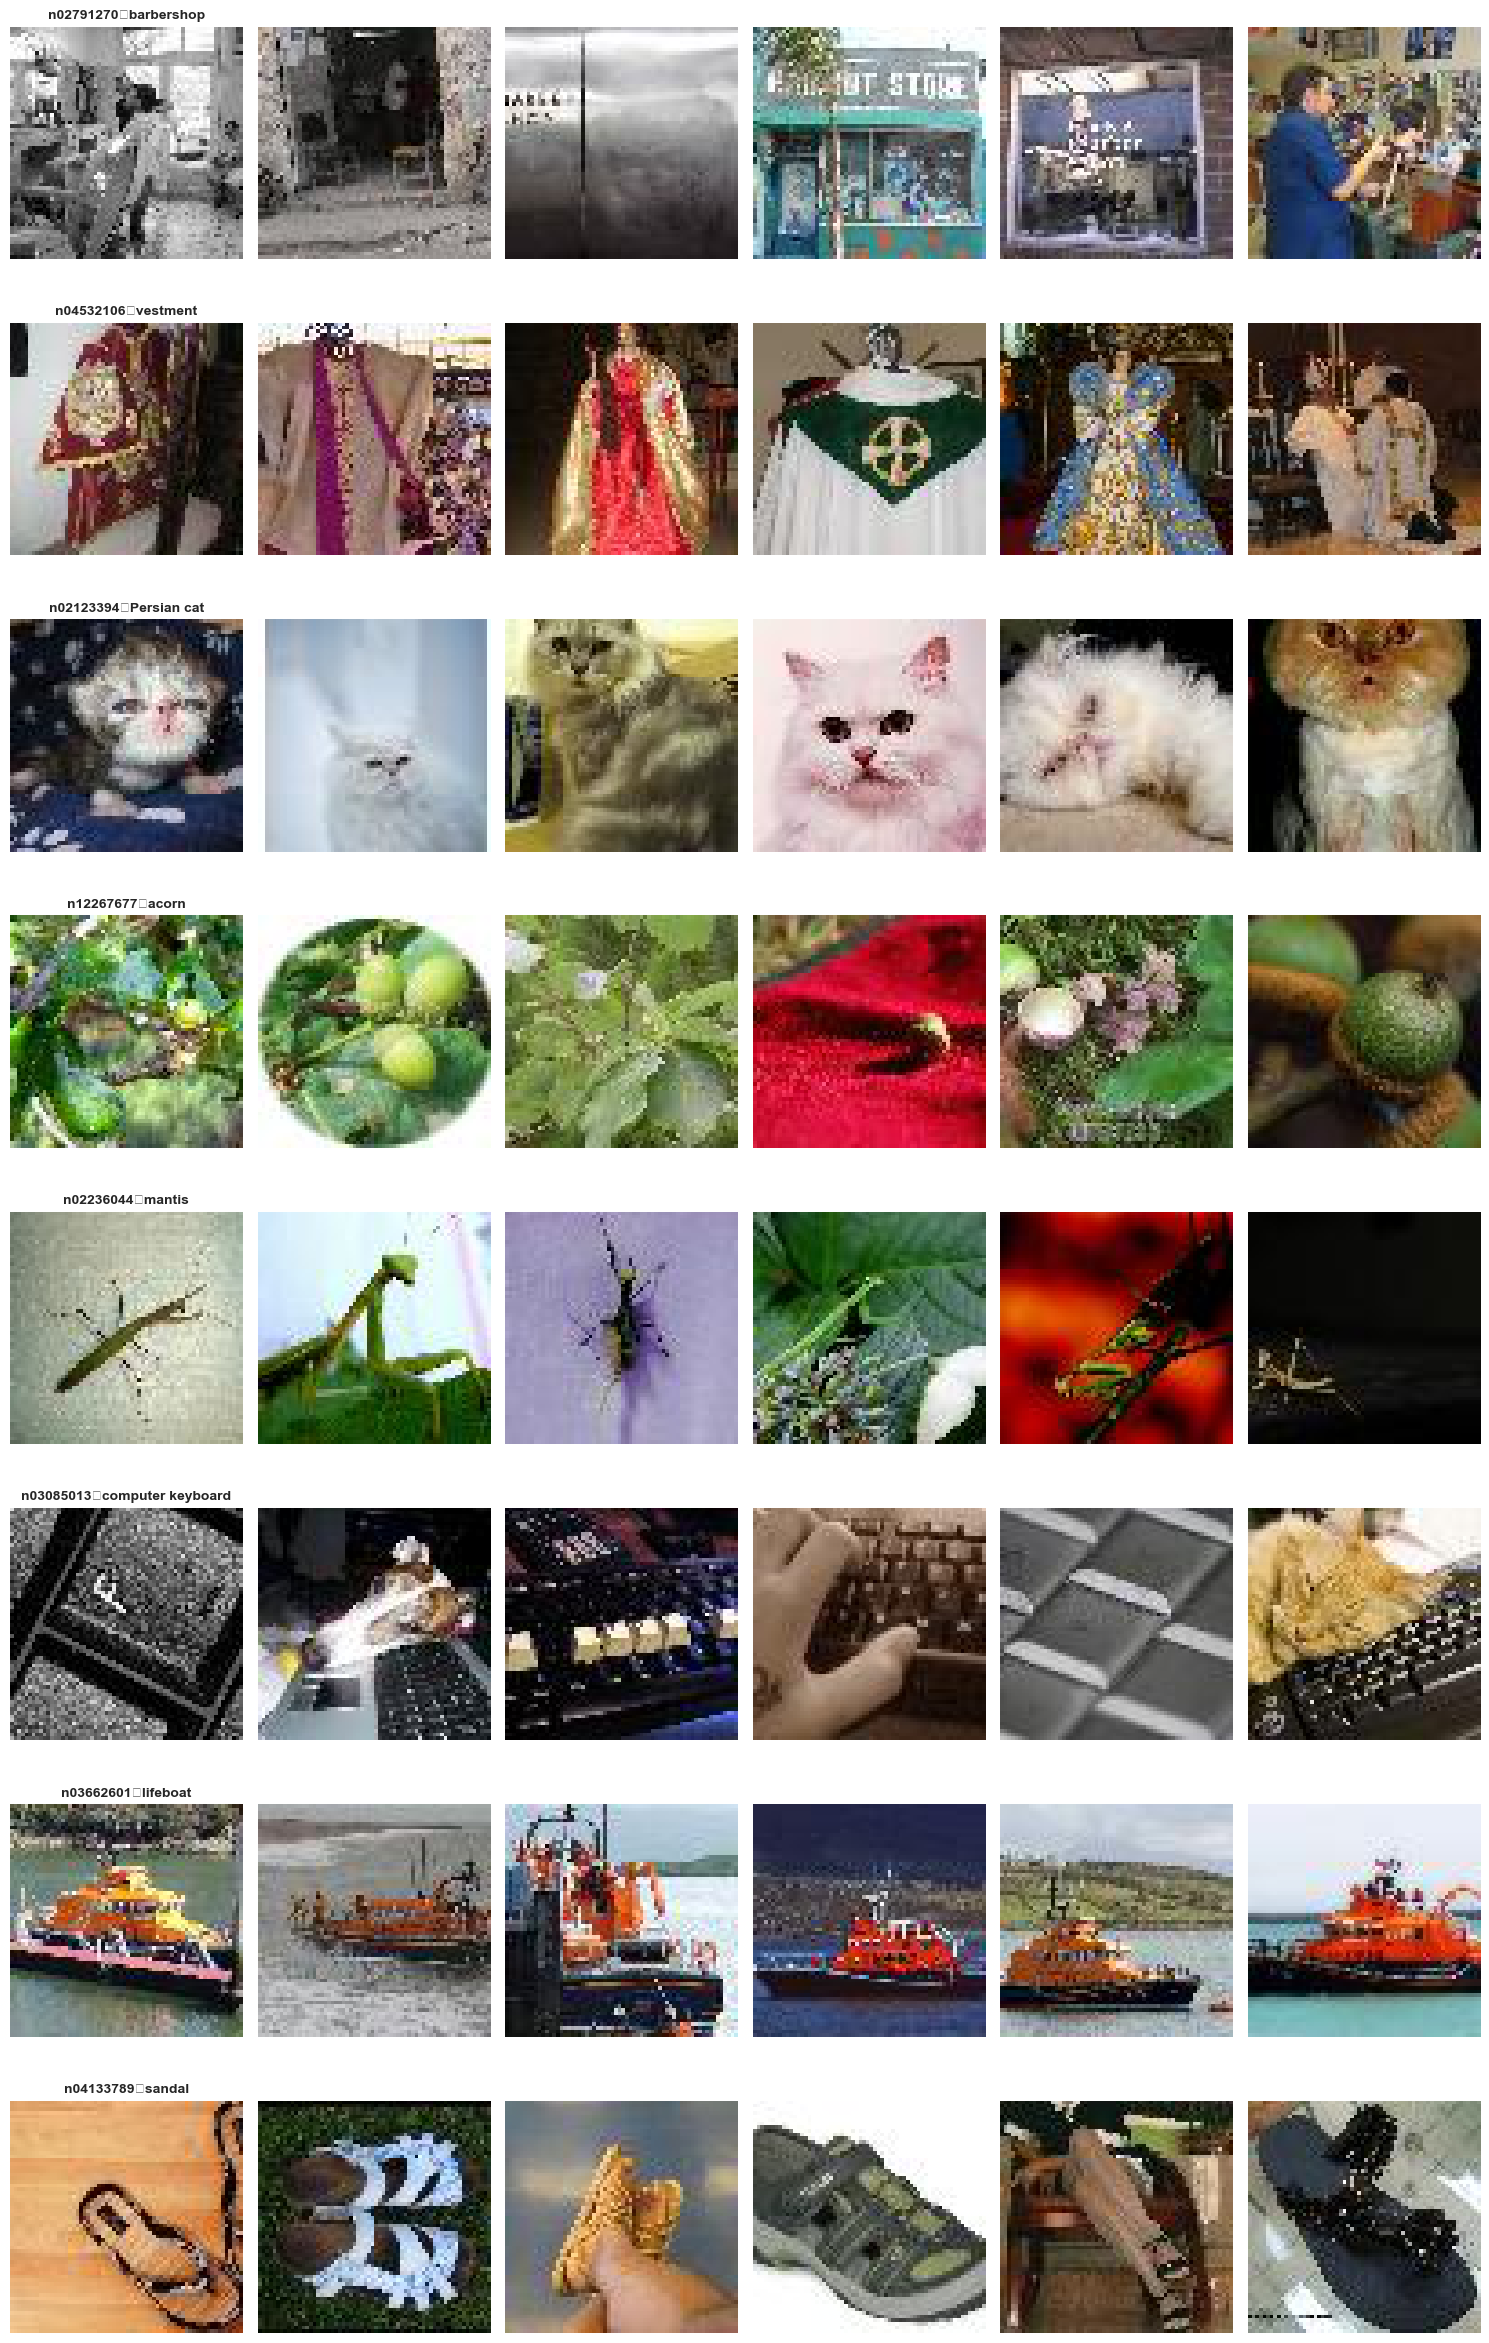

In [54]:
def visualize_sample_images(
    data_dir="../data/raw/tiny-imagenet-200",
    num_classes=10,
    num_samples_per_class=5
):
    """Visualize sample images from random classes"""
    data_path = Path(data_dir)
    train_dir = data_path / "train"
    
    # Get random classes
    class_dirs = [d for d in train_dir.iterdir() if d.is_dir()]
    random_classes = random.sample(class_dirs, min(num_classes, len(class_dirs)))
    
    # Create figure
    fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(15, 3*num_classes))
    
    for i, class_dir in enumerate(random_classes):
        images_dir = class_dir / "images"
        image_files = list(images_dir.glob("*.JPEG"))
        random_images = random.sample(image_files, min(num_samples_per_class, len(image_files)))
        
        # Get class name
        class_id = class_dir.name
        try:
            # Parse class index from WordNet ID (assuming format matches)
            class_name = class_id  # Default to ID
            for idx, name in enumerate(class_names):
                if class_id in name:
                    class_name = name.split(',')[0]  # Get first name
                    break
        except:
            class_name = class_id
        
        for j, img_file in enumerate(random_images):
            img = Image.open(img_file).convert('RGB')
            
            if num_classes == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            
            ax.imshow(img)
            ax.axis('off')
            
            if j == 0:
                ax.set_title(f'{class_name}', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

visualize_sample_images(num_classes=8, num_samples_per_class=6)

## 4. Image Statistics Analysis

Calculates the channel-wise mean and standard deviation across the RGB channels, as well as image size distribution. These statistics are crucial for proper data normalization during training. The mean and std values will be used in the preprocessing pipeline to standardize inputs.

In [55]:
def analyze_image_statistics(
    data_dir="../data/raw/tiny-imagenet-200", num_samples=1000
):
    """Analyze image statistics (mean, std, size distribution)"""
    data_path = Path(data_dir)
    train_dir = data_path / "train"

    # Collect sample images
    all_images = []
    for class_dir in train_dir.iterdir():
        if class_dir.is_dir():
            images_dir = class_dir / "images"
            all_images.extend(list(images_dir.glob("*.JPEG")))

    # Random sample
    sample_images = random.sample(all_images, min(num_samples, len(all_images)))

    # Calculate statistics
    means = []
    stds = []
    sizes = []

    transform = transforms.ToTensor()

    print(f"Analyzing {len(sample_images)} sample images...")

    for img_path in sample_images:
        try:
            img = Image.open(img_path).convert("RGB")
            sizes.append(img.size)

            img_tensor = transform(img)
            means.append(img_tensor.mean(dim=[1, 2]).numpy())
            stds.append(img_tensor.std(dim=[1, 2]).numpy())
        except Exception as e:
            continue

    # Calculate overall statistics
    mean_rgb = np.mean(means, axis=0)
    std_rgb = np.mean(stds, axis=0)

    print("\n" + "=" * 80)
    print("IMAGE STATISTICS")
    print("=" * 80)
    print(
        f"\nChannel-wise Mean (RGB):  [{mean_rgb[0]:.4f}, {mean_rgb[1]:.4f}, {mean_rgb[2]:.4f}]"
    )
    print(
        f"Channel-wise Std (RGB):   [{std_rgb[0]:.4f}, {std_rgb[1]:.4f}, {std_rgb[2]:.4f}]"
    )

    # Size distribution
    size_counter = Counter(sizes)
    print(f"\nImage Sizes:")
    for size, count in size_counter.most_common(5):
        print(f"  {size}: {count} images ({count/len(sizes)*100:.1f}%)")

    print("=" * 80 + "\n")

    return {
        "mean": mean_rgb.tolist(),
        "std": std_rgb.tolist(),
        "sizes": {str(k): v for k, v in size_counter.items()},
    }


stats = analyze_image_statistics(num_samples=2000)

Analyzing 2000 sample images...

IMAGE STATISTICS

Channel-wise Mean (RGB):  [0.4784, 0.4488, 0.4007]
Channel-wise Std (RGB):   [0.2289, 0.2254, 0.2260]

Image Sizes:
  (64, 64): 2000 images (100.0%)



## 5. Data Augmentation Techniques

Demonstrates various augmentation techniques applied to a single image. Each transformation (crop, flip, color jitter, rotation, grayscale) helps the model learn robust features by artificially increasing dataset diversity. Understanding these transformations is key to designing effective training pipelines.

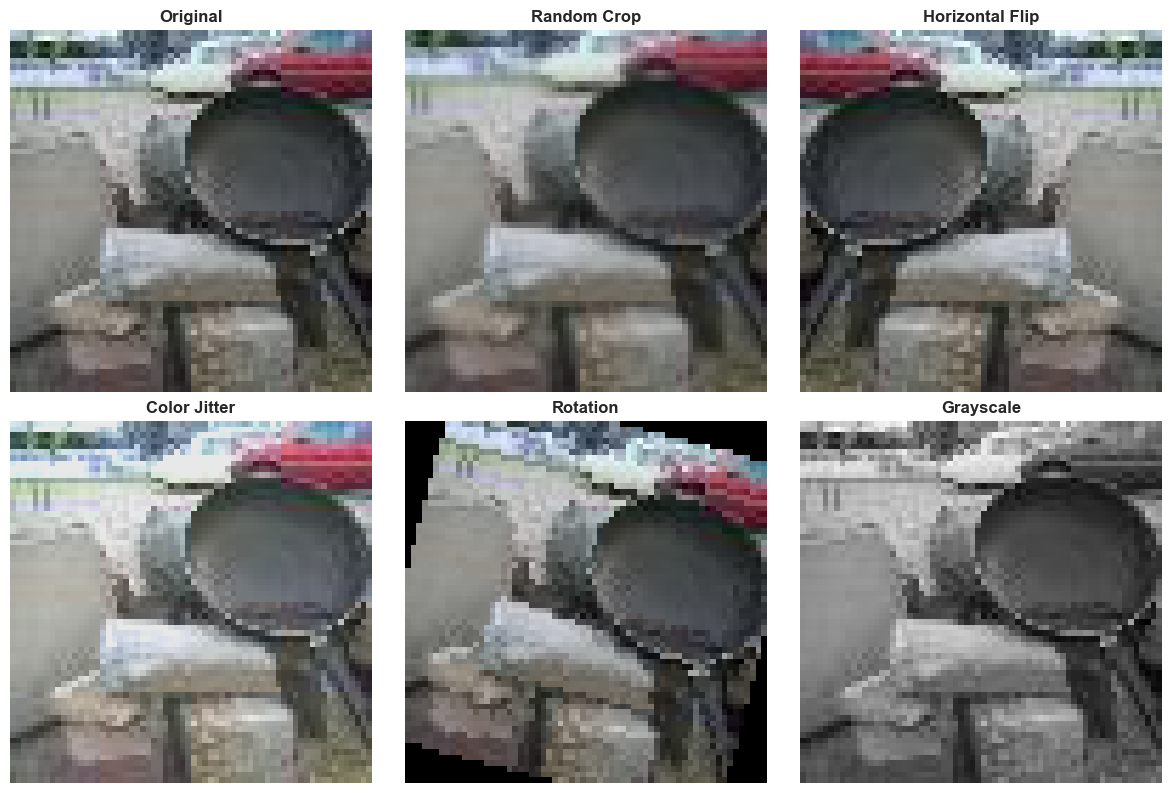

In [56]:
def visualize_augmentations(data_dir="../data/raw/tiny-imagenet-200"):
    """Visualize different augmentation techniques"""
    # Get a sample image
    data_path = Path(data_dir)
    train_dir = data_path / "train"
    class_dirs = [d for d in train_dir.iterdir() if d.is_dir()]
    sample_class = random.choice(class_dirs)
    images_dir = sample_class / "images"
    sample_image_path = random.choice(list(images_dir.glob("*.JPEG")))
    
    # Load image
    original_img = Image.open(sample_image_path).convert('RGB')
    
    # Define augmentations
    augmentations = {
        'Original': transforms.Compose([transforms.Resize((64, 64))]),
        'Random Crop': transforms.Compose([
            transforms.RandomResizedCrop(64, scale=(0.8, 1.0))
        ]),
        'Horizontal Flip': transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.RandomHorizontalFlip(p=1.0)
        ]),
        'Color Jitter': transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
        ]),
        'Rotation': transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.RandomRotation(15)
        ]),
        'Grayscale': transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.RandomGrayscale(p=1.0)
        ])
    }
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    for idx, (aug_name, aug_transform) in enumerate(augmentations.items()):
        aug_img = aug_transform(original_img)
        axes[idx].imshow(aug_img)
        axes[idx].set_title(aug_name, fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_augmentations()

## 6. Multiple Augmentation Examples

Multiple random augmentations applied to the same source image, simulating what happens during training. This illustrates how a single training image can produce diverse variations in each epoch, effectively multiplying the training data and improving model generalization.

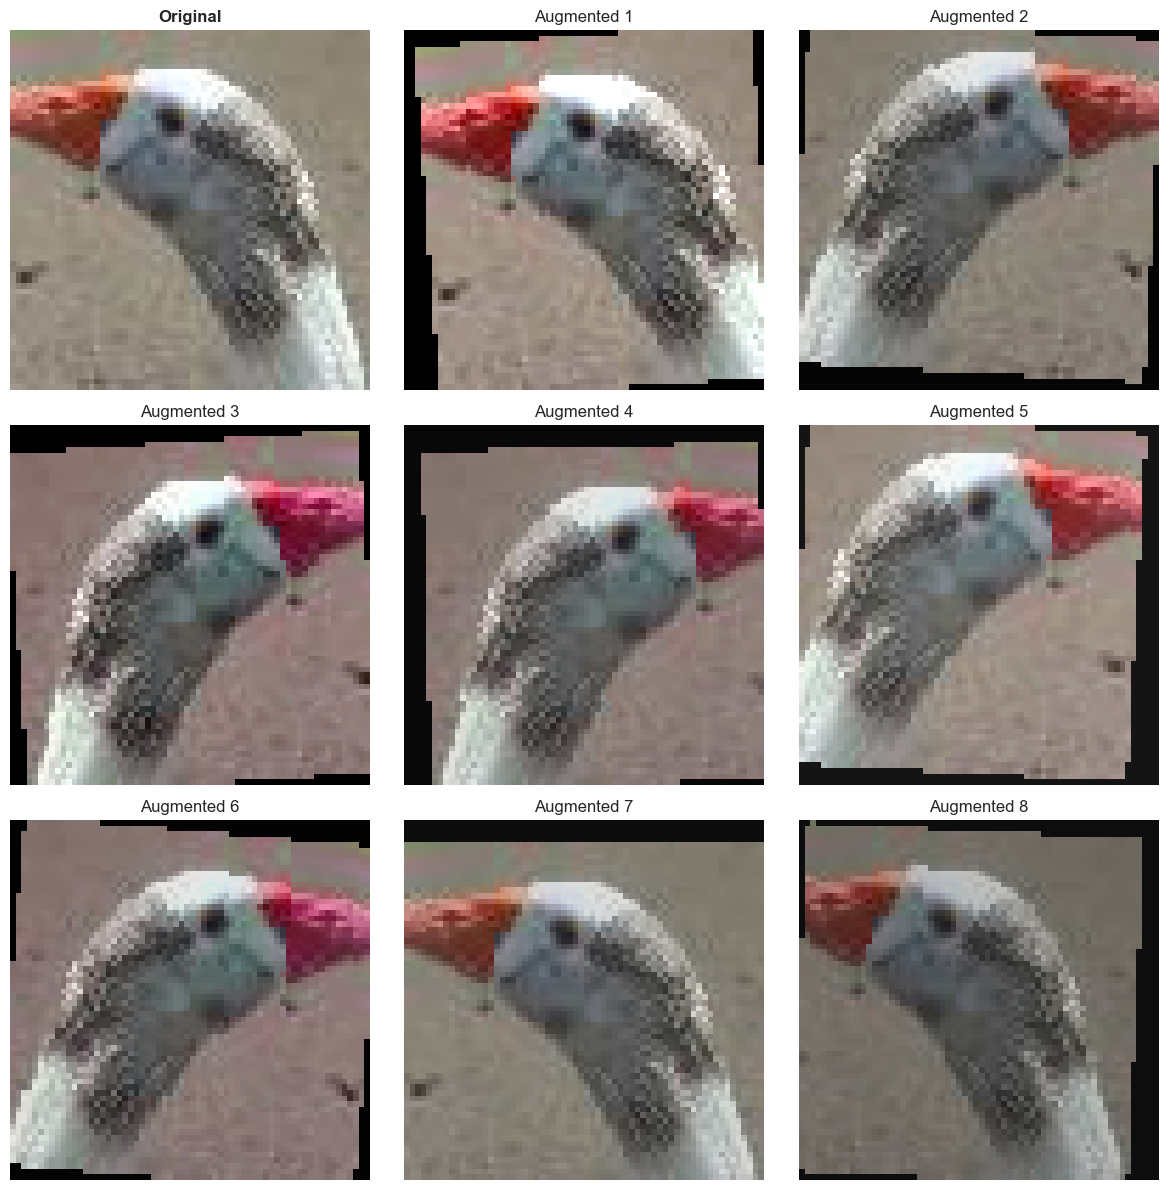

In [7]:
# Get actual training transforms used in training
strong_aug = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Get a sample image
data_path = Path("../data/raw/tiny-imagenet-200")
train_dir = data_path / "train"
class_dirs = [d for d in train_dir.iterdir() if d.is_dir()]
sample_class = random.choice(class_dirs)
images_dir = sample_class / "images"
sample_image_path = random.choice(list(images_dir.glob("*.JPEG")))
original_img = Image.open(sample_image_path).convert('RGB')

# Show original and 8 augmented versions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

# Original
axes[0].imshow(transforms.Resize((64, 64))(original_img))
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Augmented versions
for i in range(1, 9):
    aug_img = strong_aug(original_img)
    axes[i].imshow(aug_img)
    axes[i].set_title(f'Augmented {i}', fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 7. MixUp/CutMix Augmentation

Advanced data augmentation that combines two images to create synthetic training samples. This implementation randomly applies either **MixUp** (pixel-level blending) or **CutMix** (region replacement):

**Implementation Details:**
- **50% probability** to apply augmentation (when `mixup_cutmix_alpha > 0`)
- **Equal 50/50 split** between MixUp and CutMix when applied
- **Lambda (λ)** sampled from `Beta(alpha, alpha)` distribution controls mixing ratio - lower α favors extreme values (pure A or B)
- **MixUp:** `mixed_image = λ × img_A + (1-λ) × img_B`
- **CutMix:** Replaces rectangular region (size based on `sqrt(1-λ)`) from img_B into img_A
- **Loss:** `L = λ × CrossEntropy(pred, label_A) + (1-λ) × CrossEntropy(pred, label_B)`

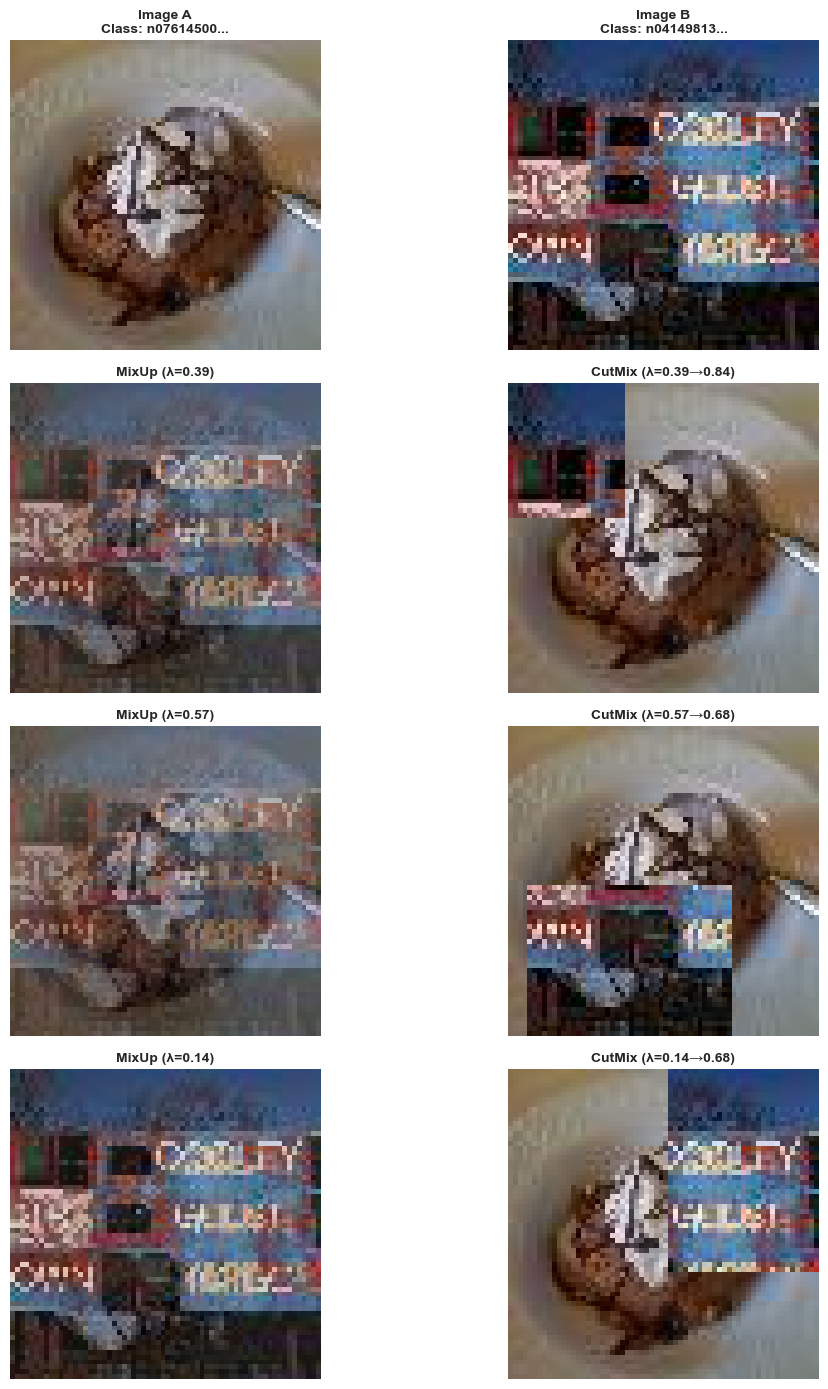

In [25]:
# Visualization: Original images + MixUp/CutMix examples with loss calculations

def apply_mixup(img1, img2, lam):
    """MixUp: blend images pixel-wise"""
    img1_t = transforms.ToTensor()(img1)
    img2_t = transforms.ToTensor()(img2)
    mixed = lam * img1_t + (1 - lam) * img2_t
    return transforms.ToPILImage()(mixed)

def apply_cutmix(img1, img2, lam):
    """CutMix: replace rectangular region (following train.py implementation)"""
    img1_t = transforms.ToTensor()(img1)
    img2_t = transforms.ToTensor()(img2)
    _, H, W = img1_t.size()
    
    # Calculate box size and position
    cut_rat = np.sqrt(1.0 - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1, y1 = np.clip(cx - cut_w // 2, 0, W), np.clip(cy - cut_h // 2, 0, H)
    x2, y2 = np.clip(cx + cut_w // 2, 0, W), np.clip(cy + cut_h // 2, 0, H)
    
    # Replace region
    mixed = img1_t.clone()
    mixed[:, y1:y2, x1:x2] = img2_t[:, y1:y2, x1:x2]
    
    # Adjust lambda based on actual cut area
    lam_adjusted = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    
    return transforms.ToPILImage()(mixed), lam_adjusted

# Get two random images from different classes
data_path = Path("../data/raw/tiny-imagenet-200")
train_dir = data_path / "train"
class_dirs = [d for d in train_dir.iterdir() if d.is_dir()]
class_A, class_B = random.sample(class_dirs, 2)

img_A = Image.open(random.choice(list((class_A / "images").glob("*.JPEG")))).convert('RGB').resize((64, 64))
img_B = Image.open(random.choice(list((class_B / "images").glob("*.JPEG")))).convert('RGB').resize((64, 64))

# Generate examples with different lambda values
lambdas = [np.random.beta(0.1, 0.1), np.random.beta(0.5, 0.5), np.random.beta(1.0, 1.0)]

fig, axes = plt.subplots(4, 2, figsize=(12, 14))

# Row 0: Original images
axes[0, 0].imshow(img_A)
axes[0, 0].set_title(f'Image A\nClass: {class_A.name[:10]}...', fontsize=10, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_B)
axes[0, 1].set_title(f'Image B\nClass: {class_B.name[:10]}...', fontsize=10, fontweight='bold')
axes[0, 1].axis('off')

# Rows 1-3: MixUp and CutMix examples
for i, lam in enumerate(lambdas, start=1):
    # MixUp
    mixup_img = apply_mixup(img_A, img_B, lam)
    axes[i, 0].imshow(mixup_img)
    axes[i, 0].set_title(f'MixUp (λ={lam:.2f})', fontsize=10, fontweight='bold')
    axes[i, 0].axis('off')
    
    # CutMix
    cutmix_img, lam_adj = apply_cutmix(img_A, img_B, lam)
    axes[i, 1].imshow(cutmix_img)
    axes[i, 1].set_title(f'CutMix (λ={lam:.2f}→{lam_adj:.2f})', fontsize=10, fontweight='bold')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()